In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import pickle
import random
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
class artStylesDataset(Dataset):
    def __init__(self,data_dir,transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [3]:
class ArtsClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ArtsClassifier,self).__init__()
        self.base_model = timm.create_model("efficientnet_b0", pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size,num_classes)
        

    def forward(self,x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [4]:
transform = transforms.Compose([
    transforms.Resize((464,300)),
    transforms.ToTensor(),
])

model_path = "artPython_model.pkl"

trainDataset = artStylesDataset("./Data", transform=transform)
validDataset = artStylesDataset("./Valid", transform=transform)

trainLoader = DataLoader(trainDataset,batch_size=16,shuffle=True)
validLoader = DataLoader(validDataset,batch_size=8,shuffle=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ArtsClassifier(num_classes=4)
model.to(device)

try:
    with open(model_path, 'rb') as file:  
        model = pickle.load(file)
except:
    pass

In [6]:
num_epoch = 50
trainLoss,valLoss = [], []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(),lr=0.002)

print("Training session start")
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    for images,labels in tqdm(trainLoader,desc="Training progress"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss/len(trainLoader.dataset)
    trainLoss.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images,labels in tqdm(validLoader,desc="Validation progress"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(validLoader.dataset)
    valLoss.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training session start


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/50 - Train loss: 0.4574486989248954, Validation loss: 0.6432849688585415


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/50 - Train loss: 0.2199368213943415, Validation loss: 0.5263750539269558


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/50 - Train loss: 0.16796229497451615, Validation loss: 0.3413237929344177


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/50 - Train loss: 0.10436531405748249, Validation loss: 0.24462448580320492


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/50 - Train loss: 0.06441808386915056, Validation loss: 0.25870431370513386


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/50 - Train loss: 0.05814199373618359, Validation loss: 0.2911109598570092


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/50 - Train loss: 0.043444871738356115, Validation loss: 0.2657309196196323


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/50 - Train loss: 0.02227007841387772, Validation loss: 0.10080236768306688


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/50 - Train loss: 0.03018556908183292, Validation loss: 0.37101750890182894


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/50 - Train loss: 0.035152831303554746, Validation loss: 0.3350266066574773


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/50 - Train loss: 0.022142631025361268, Validation loss: 0.24447287022417716


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/50 - Train loss: 0.0531546279935716, Validation loss: 0.4538374489909688


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/50 - Train loss: 0.04367841494224539, Validation loss: 0.4083722708171483


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/50 - Train loss: 0.017296260175611086, Validation loss: 0.4231278511673905


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/50 - Train loss: 0.012334921466502554, Validation loss: 0.2617671505133838


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/50 - Train loss: 0.008207243512331258, Validation loss: 0.2853544143699976


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/50 - Train loss: 0.015902360598146422, Validation loss: 0.25341316570289607


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/50 - Train loss: 0.008531679534702049, Validation loss: 0.2694777631482413


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/50 - Train loss: 0.013099723651447223, Validation loss: 0.3543987818452161


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/50 - Train loss: 0.003264328053565737, Validation loss: 0.309158937192013


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21/50 - Train loss: 0.01859321252166987, Validation loss: 0.2639479576934909


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22/50 - Train loss: 0.020004141952694777, Validation loss: 0.2068678381701195


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23/50 - Train loss: 0.012707912644662684, Validation loss: 0.18287663378341254


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24/50 - Train loss: 0.008076177259172736, Validation loss: 0.1703622253546708


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25/50 - Train loss: 0.011106375872059048, Validation loss: 0.21987374092798767


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26/50 - Train loss: 0.00761907303752993, Validation loss: 0.02755943791897491


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27/50 - Train loss: 0.009218590552528853, Validation loss: 0.3543987012446958


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28/50 - Train loss: 0.003457235148287325, Validation loss: 0.3565466203823277


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29/50 - Train loss: 0.011834361610958754, Validation loss: 0.301374263509155


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30/50 - Train loss: 0.00951311636909982, Validation loss: 0.17469711146902206


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31/50 - Train loss: 0.010401105663086808, Validation loss: 0.23257283970367076


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32/50 - Train loss: 0.018528806072703893, Validation loss: 0.10992023845180886


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33/50 - Train loss: 0.013352037015133066, Validation loss: 0.14740685854367044


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34/50 - Train loss: 0.00855467305210981, Validation loss: 0.11424412021716666


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35/50 - Train loss: 0.007652052453542661, Validation loss: 0.1704440137674642


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36/50 - Train loss: 0.005169789505802456, Validation loss: 0.13585629120474507


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37/50 - Train loss: 0.028909237807901732, Validation loss: 0.1324798021855396


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38/50 - Train loss: 0.014112880128325017, Validation loss: 0.17203624171832965


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39/50 - Train loss: 0.008581270571461661, Validation loss: 0.14240869004712547


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40/50 - Train loss: 0.005645007623302122, Validation loss: 0.13022233751537496


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41/50 - Train loss: 0.002478888476809019, Validation loss: 0.16082706555810777


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42/50 - Train loss: 0.0018156499487536628, Validation loss: 0.1609931451723326


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43/50 - Train loss: 0.0036125467430099785, Validation loss: 0.12860636540883502


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44/50 - Train loss: 0.0014035840129524896, Validation loss: 0.1437099575021759


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45/50 - Train loss: 0.0014838470809678608, Validation loss: 0.17207787754447307


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46/50 - Train loss: 0.005318737941915128, Validation loss: 0.1847624511696225


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47/50 - Train loss: 0.0067927604536054086, Validation loss: 0.1924907133676285


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48/50 - Train loss: 0.004523569009510907, Validation loss: 0.17087683947973473


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49/50 - Train loss: 0.02728790255024463, Validation loss: 0.11545084101191266


Training progress:   0%|          | 0/29 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50/50 - Train loss: 0.0019322278550908069, Validation loss: 0.08206197100713156


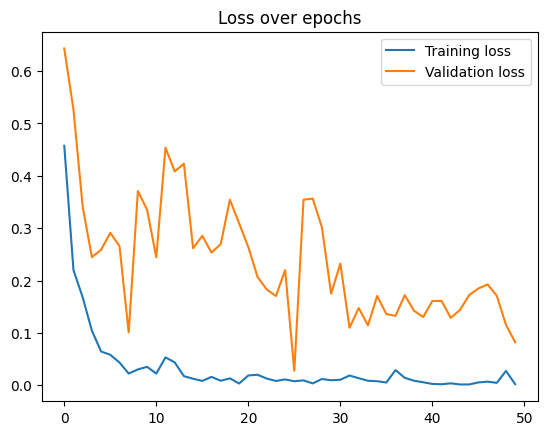

In [7]:
plt.plot(trainLoss, label="Training loss")
plt.plot(valLoss, label="Validation loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

Saving/Loading Model

In [8]:
with open(model_path, 'wb') as file:  
    pickle.dump(model, file)

Simple model test below

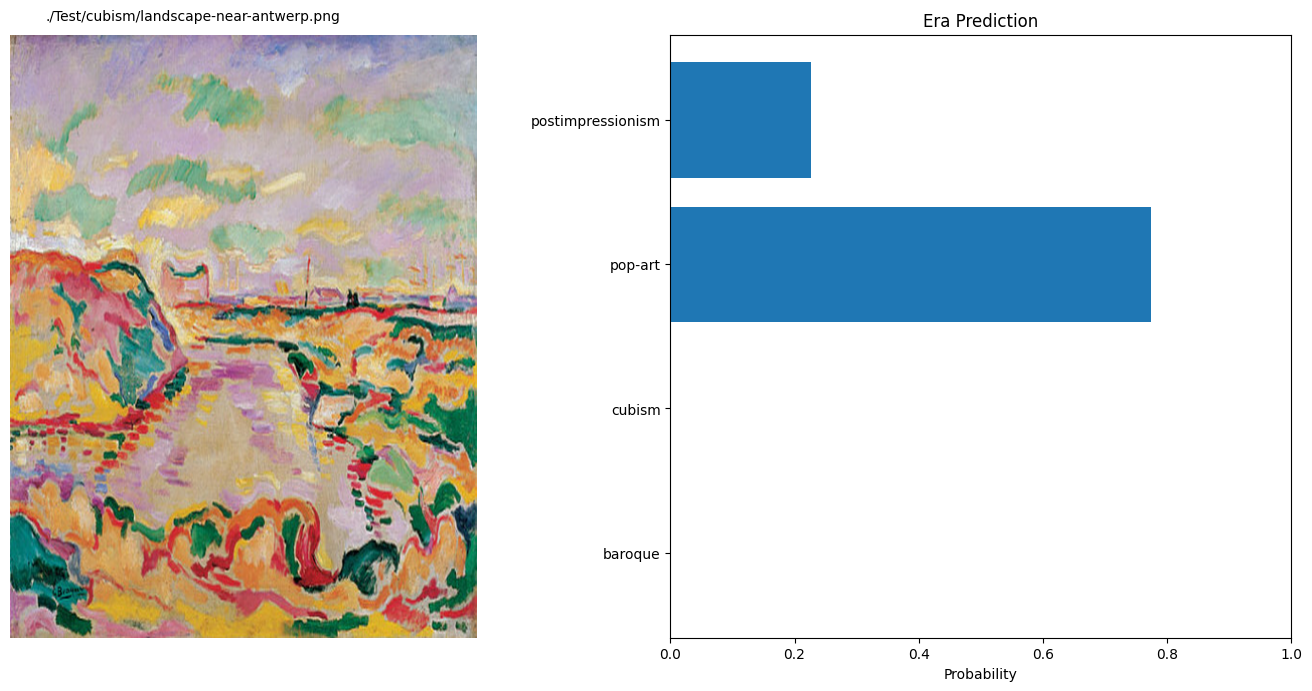

In [10]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names, picture_name):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].text(35,-15,picture_name)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Era Prediction")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

image_paths = [
    "./Test/baroque/christ-in-the-storm.png",
    "./Test/baroque/the-anatomy-lesson-of-dr-nicolaes-tulp.png",
    "./Test/pop-art/mickey.png",
    "./Test/pop-art/interior-with-mirrored-wall.png",
    "./Test/postimpressionsm/bibemus-quarry.png",
    "./Test/postimpressionsm/vase-with-peonies.png",
    "./Test/cubism/still-life-in-front-of-a-window-at-saint-raphael.png",
    "./Test/cubism/hobo.png"
]

test_image = random.choice(image_paths)

#Special Case
test_image = "./Test/cubism/landscape-near-antwerp.png"
#test_image = "./christ-in-the-storm.png"

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = trainDataset.classes 
visualize_predictions(original_image, probabilities, class_names, test_image)

END